In [224]:
import os
path = "/media/petbau/data/waymo/v0.10/3D_2D/"
store_path_thesis_pics = "/lhome/petbau/master_thesis/pics/"

if not os.path.exists(store_path_thesis_pics):
                os.mkdir(store_path_thesis_pics)

In [225]:
id = "182_2_pjHqgXW1mxalSuScBsLIUA"

In [226]:

import pandas as pd
import pickle

image_segment_relations = pd.read_csv (path + "image_segment_relations.csv")
# load the labels file

tfr_path = image_segment_relations.loc[image_segment_relations['image_id'] == id]['segment'].item()
cam = int(image_segment_relations.loc[image_segment_relations['image_id'] == id]['cam'].item())
frame_number, _,  obj_id = id.split("_", 2)

print(f"Path: {tfr_path}")
print(f"Cam: {cam}")
print(f'Frame number: {frame_number}')
print(f'Obj-ID:{obj_id}')

Path: /media/petbau/data/waymo/v1.4/individual_files/training/segment-15857303257471811288_1840_000_1860_000_with_camera_labels.tfrecord
Cam: 2
Frame number: 182
Obj-ID:pjHqgXW1mxalSuScBsLIUA


In [227]:
import tensorflow as tf 
from waymo_open_dataset import dataset_pb2
from waymo_open_dataset.utils import keypoint_data

dataset = tf.data.TFRecordDataset(tfr_path, compression_type='')
frame_counter = 0
for data in dataset:
    if frame_counter == int(frame_number):
        frame = dataset_pb2.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        break
    frame_counter +=1

tfr_labels = keypoint_data.group_object_labels(frame)
obj_labels = tfr_labels[obj_id]

In [228]:
start_x = obj_labels.camera[cam].box.center_x
start_y = obj_labels.camera[cam].box.center_y


In [229]:
print(obj_labels.camera[cam].box)

size = int(max(obj_labels.camera[cam].box.width, obj_labels.camera[cam].box.length))
start_x = int(obj_labels.camera[cam].box.center_x - size/2)
start_y = int(obj_labels.camera[cam].box.center_y - size/2)
images = sorted(frame.images, key=lambda i:i.name)
camera_image= images[cam-1]
img = tf.image.decode_jpeg(camera_image.image)
print(img.shape)
img = img[start_y:start_y+size,start_x:start_x+size,]

center_x: 557.69397
center_y: 894.3314399999999
width: 357.47994000000006
length: 148.42365000000007

(1280, 1920, 3)


In [230]:
# remove forehead label
c =0 
for kp in obj_labels.camera[cam].keypoints.keypoint:
    if kp.type == 19:
        obj_labels.camera[cam].keypoints.keypoint.pop(c)
        break
    c +=1
        

for kp in obj_labels.camera[cam].keypoints.keypoint:
    kp.keypoint_2d.location_px.x = kp.keypoint_2d.location_px.x - start_x
    kp.keypoint_2d.location_px.y = kp.keypoint_2d.location_px.y - start_y

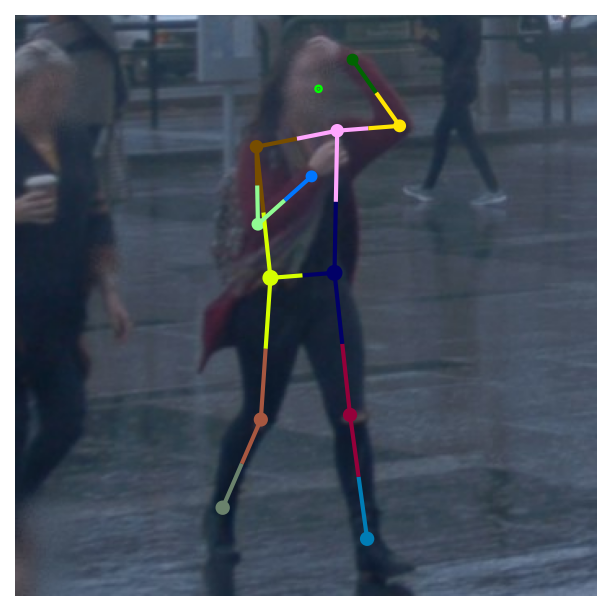

In [231]:
# waymo_open_dataset.protos.keypoint_pb2.CameraKeypoint
import numpy as np
import cv2
import matplotlib.pyplot as plt
from waymo_open_dataset.protos import keypoint_pb2
from waymo_open_dataset.utils import keypoint_draw

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150


def _imshow(ax: plt.Axes, image_np: np.ndarray):
  # image_np = cv2.copyMakeBorder(image_np, top=250, bottom=250, left=250, right=250, borderType=cv2.BORDER_CONSTANT)
  ax.imshow(image_np)
  ax.axis('off')
  ax.set_autoscale_on(False)

_, ax = plt.subplots(frameon=False, figsize=(5, 7))
_imshow(ax, img)
camera_wireframe = keypoint_draw.build_camera_wireframe(
    obj_labels.camera[cam].keypoints.keypoint)
keypoint_draw.draw_camera_wireframe(ax, camera_wireframe)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


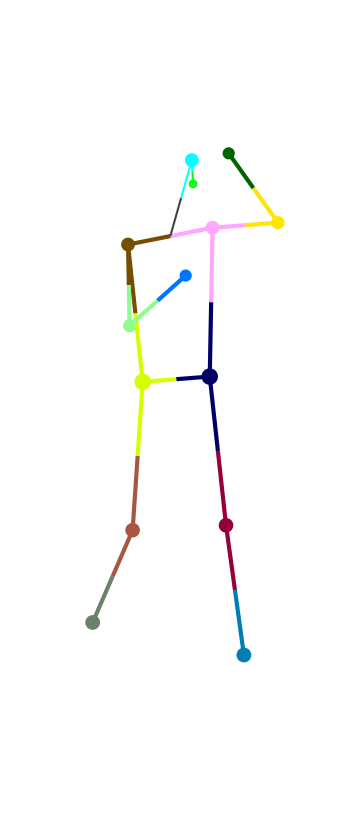

In [232]:
import pickle
# load the labels file
with open(path + "labels.pkl", 'rb') as pickle_file:
    labels = pickle.load(pickle_file)
    
    
img = cv2.imread(path + "images/" + id + ".jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cropped_camera_keypoints = []
counter = 0
for keypoint in labels[id]['keypoints_2d']:
    cam_keypoint = keypoint_pb2.CameraKeypoint()
    cam_keypoint.type = keypoint
    cam_keypoint.keypoint_2d.location_px.x = labels[id]['keypoints_2d'][keypoint]['x']
    cam_keypoint.keypoint_2d.location_px.y = labels[id]['keypoints_2d'][keypoint]['y']
    cam_keypoint.keypoint_2d.visibility.is_occluded =  labels[id]['keypoints_2d'][keypoint]['occluded']
    cropped_camera_keypoints.append(cam_keypoint)
    counter +=1

camera_wireframe = keypoint_draw.build_camera_wireframe(
    cropped_camera_keypoints)

#img = np.ones((500,150,3))*250
#keypoint_draw.OCCLUDED_BORDER_WIDTH = 3
img = np.ones(img.shape) * 255
_, ax = plt.subplots(frameon=False, figsize=(5, 7))
_imshow(ax, img)
keypoint_draw.draw_camera_wireframe(ax, camera_wireframe)


In [233]:
import plotly.graph_objects as go
import torch

def _draw_laser_points(fig: go.Figure,
                       points: np.ndarray,
                       color: str = 'gray',
                       size: int = 3):
  """Visualizes laser points on a plotly figure."""
  fig.add_trace(
      go.Scatter3d(
          mode='markers',
          x=points[:, 0],
          y=points[:, 1],
          z=points[:, 2],
          marker=dict(color=color, size=size)))

def _create_plotly_figure() -> go.Figure:
  """Creates a plotly figure for 3D visualization."""
  fig = go.Figure()
  axis_settings = dict(
      showgrid=True,
      zeroline=True,
      showline=True,
      showbackground=True,
      showaxeslabels=True,
      showticklabels=True)
  fig.update_layout(
      width=1000,
      height=1000,
      showlegend=False,
      scene=dict(
          aspectmode='data',  # force xyz has same scale,
          xaxis=axis_settings,
          yaxis=axis_settings,
          zaxis=axis_settings,
      ),
  )
  return fig
  









inv_extrinsics = np.linalg.inv(labels[id]['extrinsic'])
root_vehicle = np.array([labels[id]['bb_3d']['center_x'], labels[id]['bb_3d']['center_y'], labels[id]['bb_3d']['center_z'], 1])
print(root_vehicle)
root = inv_extrinsics @ root_vehicle
root = root[:-1] / root[-1]
origin_unit_vect = root / torch.norm(torch.tensor(root))
print(root)
camera_vect = - origin_unit_vect * 3
pc_vehicle =  labels[id]['lidar']
pc_vehicle = np.concatenate((pc_vehicle, np.ones([pc_vehicle.shape[0], 1])), axis=1)
pc_sensor = np.einsum('ij,kj->ki', inv_extrinsics, pc_vehicle)
pc_sensor = pc_sensor[:, :3] / pc_sensor[:, -1].reshape(-1, 1)
pc = pc_sensor - root


## Would also need transformation into sensor system....
# keypoints_3D = []
# for keypoint in labels[id]['keypoints_3d']:
#     laser_keypoint = keypoint_pb2.LaserKeypoint()
#     laser_keypoint.type = keypoint
#     laser_keypoint.keypoint_3d.location_m .x = labels[id]['keypoints_3d'][keypoint]['x']
#     laser_keypoint.keypoint_3d.location_m .y = labels[id]['keypoints_3d'][keypoint]['y']
#     laser_keypoint.keypoint_3d.location_m .z = labels[id]['keypoints_3d'][keypoint]['z']
#     laser_keypoint.keypoint_3d.visibility.is_occluded =  labels[id]['keypoints_3d'][keypoint]['occluded']
#     keypoints_3D.append(laser_keypoint)

# laser_wireframe = keypoint_draw.build_laser_wireframe(keypoints_3D)



fig = _create_plotly_figure()
# keypoint_draw.draw_laser_wireframe(fig, laser_wireframe)
_draw_laser_points(fig, pc)

eye = (camera_vect[0].item(), camera_vect[1].item(), camera_vect[2].item())

camera = dict(
    eye=dict(x=eye[0], y=eye[1], z=eye[2])
)

fig.layout.scene.xaxis.showaxeslabels = False
fig.layout.scene.xaxis.showbackground = False
fig.layout.scene.xaxis.showticklabels = False
fig.layout.scene.yaxis.showaxeslabels = False
fig.layout.scene.yaxis.showbackground = False
fig.layout.scene.yaxis.showticklabels = False
fig.layout.scene.zaxis.showaxeslabels = False
fig.layout.scene.zaxis.showbackground = False
fig.layout.scene.zaxis.showticklabels = False


fig.update_layout(scene_camera=camera)

fig.write_image(store_path_thesis_pics + id + "_pc.pdf")

fig.show()

[7.56082323 9.04612395 0.97808779 1.        ]
[10.61344436  1.96924706 -1.2893693 ]
